### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from tqdm.notebook import tqdm

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, criterion='gini',
                 max_features=None, random_state=None):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.random_state = random_state
        if self.random_state is not None:
            np.random.seed(random_state)
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.feature_importances_ = None
        self.criterion = criterion
        self.max_features = max_features
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

        if max_features == 'sqrt' or max_features == 'auto':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features is None:
            self.get_feature_ids = self.__get_feature_ids_N
        elif not isinstance(max_features, int) or max_features <= 0:
            raise RuntimeError(f'Invalid max_features argument - {self.max_features}')
        
        if criterion == 'gini':
            self.__impurity_Q = self.__gini_Q
            self.__F = self.__gini_F
        elif criterion == 'entropy':
            self.__impurity_Q = self.__entropy_Q
            self.__F = self.__entropy_F
        elif criterion == 'misclass':
            self.__impurity_Q = self.__misclass_Q
            self.__F = self.__misclass_F
        else:
            raise RuntimeError(f'Invalid criterion argument - {self.max_features}')

    def __gini_Q(self, y):
        return 1 - np.sum((np.bincount(y) / y.size) ** 2)
    
    def __entropy_Q(self, y):
        _, p = np.unique(y, return_counts=True)
        return -np.sum((p / y.size) * np.log2(p / y.size))

    def __misclass_Q(self, y):
        return 1 - np.max(np.bincount(y) / y.size)
    
    def __gini_F(self, y_left, y_right):
        return np.sum(np.bincount(y_left) ** 2) / y_left.size + np.sum(np.bincount(y_right) ** 2) / y_right.size
    
    def __entropy_F(self, y_left, y_right):
        left_size = y_left.size
        right_size = y_right.size
        _, y_left = np.unique(y_left, return_counts=True)
        _, y_right = np.unique(y_right, return_counts=True)
        return left_size + right_size + np.sum(y_left * (np.log(y_left / left_size))) + np.sum(y_right * (np.log(y_right / right_size)))
    
    def __misclass_F(self, y_left, y_right):
        return np.max(np.bincount(y_left)) + np.max(np.bincount(y_right))

    def __get_feature_ids_N(self, features_count):
        indices = np.arange(features_count)
        np.random.shuffle(indices)
        features_count = min(features_count, self.max_features) if self.max_features else features_count
        return indices[:features_count]
    
    def __get_feature_ids_log2(self, features_count):
        indices = np.arange(features_count)
        np.random.shuffle(indices)
        return indices[:int(np.log2(features_count))]
    
    def __get_feature_ids_sqrt(self, features_count):
        indices = np.arange(features_count)
        np.random.shuffle(indices)
        return indices[:int(np.sqrt(features_count))]

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        best_id = np.nan
        best_score = -np.inf
        best_threshold = np.nan

        feature_ids = self.get_feature_ids(x.shape[1])

        x_all_sorted = np.sort(x, axis=0)
        y_all_sorted = y[np.argsort(x, axis=0)]

        for i in feature_ids:
            x_sorted, y_sorted = x_all_sorted[:, i], y_all_sorted[:, i]
            
            idx = np.where((y_sorted[:-1] != y_sorted[1:]) & (x_sorted[1:] != x_sorted[:-1]))[0]
            idx += 1
            idx = idx[(idx >= self.min_samples_split) & (idx <= y_sorted.size - self.min_samples_split)]
            if idx.size == 0:
                continue
            
            scores = np.array([self.__F(y_sorted[j:], y_sorted[:j]) for j in idx])
            best_j = np.argmax(scores)
            score = scores[best_j]

            if score > best_score:
                best_score = score
                best_id = i
                best_threshold = (x_sorted[idx[best_j]] + x_sorted[idx[best_j] - 1]) / 2.0 if idx[best_j] > 0 else np.nan

        return best_id, best_threshold

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        unique_y, class_count = np.unique(y, return_counts=True)
        bincount_y = np.bincount(y)
        
        if self.max_depth is not None and depth == self.max_depth or \
           self.min_samples_split is not None and x.shape[0] < self.min_samples_split or \
           unique_y.size == 1:
           # Листовой узел, предсказание - класс с максимальной долей вхождения

           self.tree[node_id] = (self.LEAF_TYPE,
                                 np.argmax(bincount_y), 
                                 bincount_y / y.size)
           return
        
        feature_id, threshold = self.__find_threshold(x, y)
        if np.isnan(threshold):
           self.tree[node_id] = (self.LEAF_TYPE,
                                 np.argmax(bincount_y), 
                                 bincount_y / y.size)
           return
        
        x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)

        self.feature_importances_[feature_id] += self.__impurity_Q(y) -\
            (y_left.size * self.__impurity_Q(y_left) + y_right.size * self.__impurity_Q(y_right)) / y.size

        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold)

        self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = np.zeros(x.shape[1])
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)
        return self

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

    def __repr__(self):
        return f'MyDecisionTreeClassifier(min_samples_split={self.min_samples_split}, max_depth={self.max_depth}, criterion={self.criterion}, max_features={self.max_features}, random_state={self.random_state})'

In [ ]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [ ]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [ ]:
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

0.9444444444444444


In [ ]:
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [ ]:
%time clf.fit(X_train, y_train)

CPU times: user 2.15 ms, sys: 40 µs, total: 2.19 ms
Wall time: 6.18 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
%time my_clf.fit(X_train, y_train)

CPU times: user 27.5 ms, sys: 0 ns, total: 27.5 ms
Wall time: 29.5 ms


MyDecisionTreeClassifier(min_samples_split=2, max_depth=None, criterion=gini, max_features=None, random_state=None)

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [ ]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

In [ ]:
df.shape

(8378, 195)

In [ ]:
df = df.iloc[:, :97]

df = df.drop(['id'], axis = 1)
df = df.drop(['from'], axis = 1)
df = df.drop(['idg'], axis = 1)
df = df.drop(['condtn'], axis = 1)
df = df.drop(['round'], axis = 1)
df = df.drop(['wave'], axis = 1)
df = df.drop(['position', 'positin1'], axis = 1)
df = df.drop(['order'], axis = 1)
df = df.drop(['partner'], axis = 1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], axis = 1)

df = df.dropna(subset = ['age', 'imprelig', 'imprace'])
df = df.drop(['field'], axis = 1)
df = df.drop(['undergra'], axis = 1)

df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'zipcode'] = df.loc[:, 'zipcode'].str.replace(',', '').astype(np.float) # df = df.drop(['zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

df['mn_sat'] = df['mn_sat'].fillna(0.0)
df['tuition'] = df['tuition'].fillna(0.0)
df['income'] = df['income'].fillna(0.0)
df['career_c'] = df['career_c'].fillna(0.0)

df = df.dropna(subset=['date'])
df = df.drop(['career'], axis = 1)
df = df.drop(['sports','tvsports','exercise','dining',
              'museums','art','hiking','gaming',
              'clubbing','reading','tv','theater','movies',
              'concerts','music','shopping','yoga'], axis = 1)
df = df.drop(['expnum'], axis = 1)

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 
                                        'intel1_1', 'fun1_1', 
                                        'amb1_1', 'shar1_1']].sum(axis = 1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
            'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                        'intel2_1', 'fun2_1',
                                        'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
            'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis = 1)

df = df.dropna()
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

df_male = df.query('gender == 1').drop_duplicates(subset = ['iid', 'pid'])\
                                 .drop(['gender'], axis = 1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset = ['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis = 1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'
df = df_male.join(df_female)
df = df.fillna(value = 0)

X = np.array(df.drop(['match'], axis = 1))
y = np.array(df['match'])

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [ ]:
from itertools import product

In [ ]:
cv = KFold(n_splits = 3, shuffle = True)


Best score is 0.8490929720714687, params
(20, 11, 'misclass')


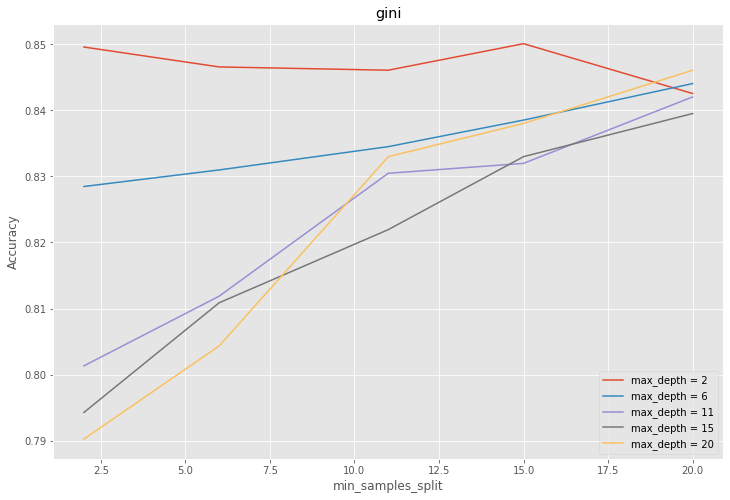

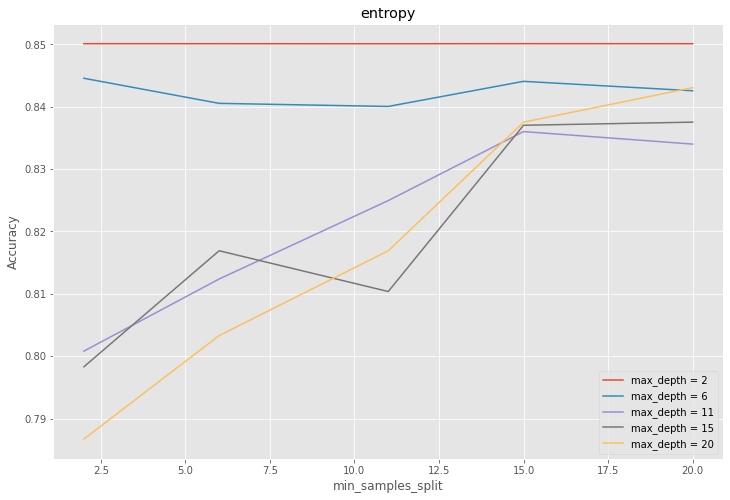

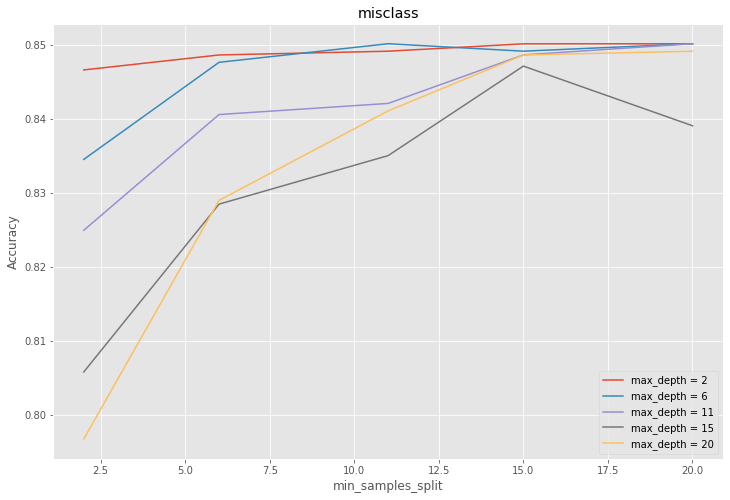

In [ ]:
parametrs = {
    'min_samples_split': np.linspace(2, 20, 5, dtype=int),
    'max_depth': np.linspace(2, 20, 5, dtype=int),
    'criterion': ['gini', 'entropy', 'misclass'],
}

best_score = 0
best_params = None

scores = {}

for min_samples_split, max_depth, criterion in tqdm(list(product(*parametrs.values()))):
    if criterion not in scores:
        scores[criterion] = {}
    if max_depth not in scores[criterion]:
        scores[criterion][max_depth] = []
    
    clf = MyDecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=max_depth, criterion=criterion)

    idx = cv.split(X)
    cv_scores = []
    for train_idx, test_idx in idx:
        clf.fit(X[train_idx], y[train_idx])
        cv_scores.append(accuracy_score(y[test_idx], clf.predict(X[test_idx])))
    
    score = np.mean(cv_scores)

    if score > best_score:
        best_params = (min_samples_split, max_depth, criterion)
        best_score = score
            
    scores[criterion][max_depth].append(score)
            
print(f"Best score is {score}, params\n{best_params}")

for criterion in parametrs['criterion']:
    for max_depth in parametrs['max_depth']:
        plt.plot(parametrs['min_samples_split'], scores[criterion][max_depth], label=f'max_depth = {max_depth}')
    
    plt.xlabel('min_samples_split')
    plt.ylabel('Accuracy')
    plt.title(criterion)
    plt.legend()
    plt.show()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [ ]:
clf = MyDecisionTreeClassifier(min_samples_split=best_params[0], max_depth=best_params[1])
print(clf.fit(X, y))
feature_importance = clf.get_feature_importance()

indices = np.argsort(feature_importance)[::-1]
feature_importance[indices]

MyDecisionTreeClassifier(min_samples_split=20, max_depth=11, criterion=gini, max_features=None, random_state=None)


array([1.51446819e-01, 8.51052686e-02, 5.33229506e-02, 5.03293344e-02,
       3.96974952e-02, 3.04687402e-02, 2.44207703e-02, 1.77977286e-02,
       1.17028862e-02, 1.08127797e-02, 9.63099167e-03, 7.49720925e-03,
       6.06822737e-03, 5.19996992e-03, 4.93882463e-03, 4.30438941e-03,
       2.10558705e-03, 1.92286635e-03, 1.49310328e-03, 1.03031232e-03,
       7.17231486e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
features = df.drop(['match'], axis = 1).columns.values
print(*features[indices[:10]], sep='\n')

int_corr
pid
samerace
amb1_1
iid
amb2_1
goal
fun3_1
attr3_1
attr2_1


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.


Дольше всего я разбирался с тем, как считать функцию потерь, по которой мы считаем признак, по которому брать разделение (и как это потом ускорять).

### ВАШ ОТЗЫВ ЗДЕСЬ

